# The Magic of Julia Data Types

Unlike python, where classes _own_ methods, in Julia there are no _classes_ in the python sense:
* Data types define structured data _and nothing else_ (mostly)
* Functions can have multiple definitions (each new definition of a function is called a _method_)
* The Julia compiler chooses which method to apply to a function call based on the type of _all_ input arguments (i.e. Multiple Dispatch)

This might be a bit strange for python users: classes look "inside-out" with method definitions accompanying data types.

For encapsulation, use Modules!

## Composite Data Types (Classes)

Let's define an ordered pair of reals

In [1]:
struct OrderedPair <: Number
    x::Real
    y::Real
    
    OrderedPair(x::Real, y::Real) = x > y ? error("out of order") : new(x,y)
end

The encapsulated function: `OrderedPair(x,y) = x > y ? error("out of order") : new(x,y)` defines a constructor `__init__(self, x, y)` that ensure that the ordered pair stays ordered. This is a one-line function definition that is equivalent to:
```julia
function OrderedPair(x,y)
    if x > y
        error("out of order")
    end
    new(x,y)
end
```

Let's define some math: addition and subtraction: In python we would define `__add__` and `__sub__`. In julia we define new _methods_ for `Base.+` and `Base.-` as well a conversion and promotion rules for our custom data type. This way our `OrderedPair` is a first-class citizen ... just like `Float64` :)

In [2]:
import Base: +, -, convert, promote_rule

function +(a::OrderedPair, b::OrderedPair)
    x_new = a.x + b.x
    y_new = a.y + b.y
    OrderedPair(x_new, y_new)
end

# One-liners can seem a bit magical
-(a::OrderedPair, b::OrderedPair) = OrderedPair(a.x - b.x, a.y - b.y)

# Getting these right might require some experimenting. Note how OrderedPair extends Number.
convert(::Type{OrderedPair}, x::Real) = OrderedPair(x, x)
promote_rule(::Type{OrderedPair}, ::Type{<:Real}) = OrderedPair

promote_rule (generic function with 125 methods)

In [3]:
p1 = OrderedPair(1, 2)
p2 = OrderedPair(10, 20)

OrderedPair(10, 20)

In [4]:
p1 + p2

OrderedPair(11, 22)

In [5]:
p1 - p2

LoadError: out of order

In [6]:
p2 - p1

OrderedPair(9, 18)

In [7]:
convert(OrderedPair, 20.)

OrderedPair(20.0, 20.0)

In [8]:
p1 + 20.

OrderedPair(21.0, 22.0)

## Generics and `UnionAll` Data Types

We can use curly braces and the `where` keyword to define generic types. These are basically templates. The `<:` symbol restricts the possible inputs to the generic type `T`

In [9]:
struct OrderedPair2{T} <: Number where T <: Number
    x::T
    y::T
    OrderedPair2(x::T, y::T) where T = x > y ? error("out of order") : new{T}(x,y)
end

This now generates different specializations based on the type of `x`, and `y`

In [10]:
p = OrderedPair2(1., 2.)

OrderedPair2{Float64}(1.0, 2.0)

In [11]:
p2 = OrderedPair2(1, 2)

OrderedPair2{Int64}(1, 2)

## Julia Magic: Autodifferentiation in 4 lines

Take as an example the babylonian algorithm to calculate $\sqrt{x}$
> Repeat $ t \leftarrow  \frac{t+\frac{x}{t}}{2} $ until $t$ converges to $\sqrt{x}$.

For illustration we will use 10 iterations

In [12]:
function babylonian(x; N::Integer = 10) 
    t = (1+x)/2
    for i = 2:N
        t = (t + x/t)/2 
    end    
    t
end

babylonian (generic function with 1 method)

Check: `sqrt(100) == 10`

In [13]:
babylonian(100)

10.0

In [14]:
x=2; babylonian(x), √x  # Type \sqrt+<tab> to get the symbol

(1.414213562373095, 1.4142135623730951)

Let's look at the convergence behaviour

In [15]:
x = range(0.01, 10, length=100)
y = [babylonian(x, N = N) for x = x, N = 1:5];

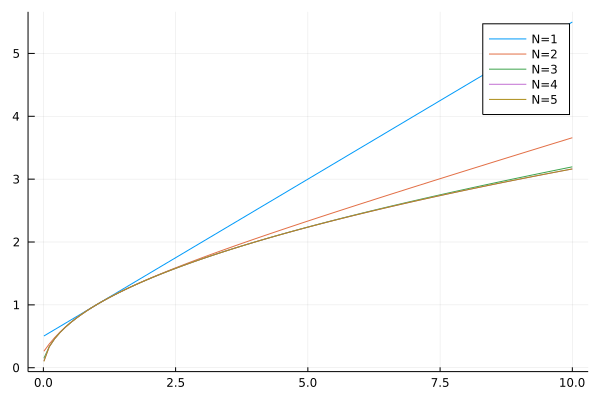

In [16]:
using Plots

plot(x, y[:, 1], label="N=1")
for i=2:5
    plot!(x, y[:, i], label="N=$(i)")
end
plot!()

### ... and now the derivative almost by magic

Define a dual type -- a methematical object that's a function-derivative pair

In [44]:
struct D <: Number
    f::Tuple{Float64,Float64}
end

The first element follows the normal rules of arithmetic. But the second element implements:
* Sum Rule: $(x+y)' = x' + y'$
* Quotient Rule: $(\frac{x}{y})' = \frac{yx'-xy'}{y^2}$

In [45]:
import Base: +, -, *, /, convert, promote_rule
+(x::D, y::D) = D(x.f .+ y.f)
-(x::D, y::D) = D(x.f .- y.f)
*(x::D, y::D) = D((x.f[1]*y.f[1], (x.f[2]*y.f[1] + x.f[1]*y.f[2])))
/(x::D, y::D) = D((x.f[1]/y.f[1], (y.f[1]*x.f[2] - x.f[1]*y.f[2])/y.f[1]^2))
convert(::Type{D}, x::Real) = D((x,zero(x)))
promote_rule(::Type{D}, ::Type{<:Number}) = D

promote_rule (generic function with 153 methods)

Let's compute the derivative of $\sqrt{x}$ at $x=25$

In [48]:
x = 25
x̂ = D((x, 1))

D((25.0, 1.0))

In [49]:
(√x, .5/√x)

(5.0, 0.1)

In [50]:
babylonian(x̂)

D((5.0, 0.1))